In [1]:
import glob
import os
import time
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from scipy.stats import zscore

In [2]:
# settings
inputlayername = 'inception3a' #input('enter layer name:')

# imagenet image dir
im_image_dir = '/nfs/z1/userhome/GongZhengXin/NVP/data_upload/NOD/stimuli/imagenet'
cifti_dir = '/nfs/z1/userhome/GongZhengXin/NVP/data_upload/NOD/derivatives/ciftify'
# experiment info
sub = 'sub-02'

In [12]:
sessions = ['imagenet01','imagenet02','imagenet03','imagenet04']
# device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# pretrained net weights
pretrained_weights_path = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/googlenet-1378be20.pth'

# training params
layer = {'name': inputlayername}

# output paths
image_name_path = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/prep/image_names'
image_activations_path = '/nfs/z1/userhome/GongZhengXin/NVP/NaturalObject/data/code/nodretinotopy/mfm_locwise_fullpipeline/prep/image_activations'


In [13]:
if os.path.exists(os.path.join(image_name_path, f'{sub}_imagenet.csv')):
    with open(os.path.join(image_name_path, f'{sub}_imagenet.csv'), 'r') as f:
        image_paths = [_.replace('\n', '') for _ in f.readlines()] 
else:
    # collect run folder
    folders = []
    for session in sessions:
        for run_folder in glob.glob(os.path.join(cifti_dir, sub, "results/", f"*{session}*")):
            folders.append(run_folder)
    folders = sorted(folders)

    # collect image names
    image_names_files = []
    for folder in folders:
        for img_label_txt in glob.glob(os.path.join(folder, "*label.txt")): 
            image_names_files.append(img_label_txt) # 顺序为 1 10 2 3 ...

    # compose image paths
    image_paths = []
    for image_name_file in image_names_files:
        with open(image_name_file, 'r') as f:
            image_names = [ _.split('/')[-1].replace('\n', '') for _ in f.readlines() ]
            image_path = [ os.path.join(im_image_dir, _.split('_')[0], _) for _ in image_names]
        image_paths.extend(image_path)

    with open(os.path.join(image_name_path, f'{sub}_imagenet.csv'), 'w') as f:
        f.writelines('\n'.join(image_paths))


# intial preprocess
transform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
])

# 读取和转换图片
images = [Image.open(p).convert('RGB') for p in image_paths]
images = [transform(img) for img in images]

# 初始化数据和模型
num_images = len(images[0:10])
x_data = torch.stack(images[0:10]).to(device)

In [8]:
x_data.shape

torch.Size([10, 3, 227, 227])

In [10]:
# initialize structure
net = models.googlenet()
# load parameters
net.load_state_dict(torch.load(pretrained_weights_path))
net.to(device)
net.eval()

# 用于存储激活值的列表
activations = []

# 钩子函数
def hook(module, input, output):
    activations.append(output.cpu().detach().numpy())
    print('.',end=' ')
# 用 named_modules 获取所有层的名称和模块，并在特定层上注册钩子
for name, module in net.named_modules():
    if '.' in name:
        print(name, end=',')
    else:
        print(name)


conv1
conv1.conv,conv1.bn,maxpool1
conv2
conv2.conv,conv2.bn,conv3
conv3.conv,conv3.bn,maxpool2
inception3a
inception3a.branch1,inception3a.branch1.conv,inception3a.branch1.bn,inception3a.branch2,inception3a.branch2.0,inception3a.branch2.0.conv,inception3a.branch2.0.bn,inception3a.branch2.1,inception3a.branch2.1.conv,inception3a.branch2.1.bn,inception3a.branch3,inception3a.branch3.0,inception3a.branch3.0.conv,inception3a.branch3.0.bn,inception3a.branch3.1,inception3a.branch3.1.conv,inception3a.branch3.1.bn,inception3a.branch4,inception3a.branch4.0,inception3a.branch4.1,inception3a.branch4.1.conv,inception3a.branch4.1.bn,inception3b
inception3b.branch1,inception3b.branch1.conv,inception3b.branch1.bn,inception3b.branch2,inception3b.branch2.0,inception3b.branch2.0.conv,inception3b.branch2.0.bn,inception3b.branch2.1,inception3b.branch2.1.conv,inception3b.branch2.1.bn,inception3b.branch3,inception3b.branch3.0,inception3b.branch3.0.conv,inception3b.branch3.0.bn,inception3b.branch3.1,incepti

In [22]:
layer['name'] = 'conv2'

In [23]:
# initialize structure
net = models.googlenet()
# load parameters
net.load_state_dict(torch.load(pretrained_weights_path))
net.to(device)
net.eval()

# 用于存储激活值的列表
activations = []

# 钩子函数
def hook(module, input, output):
    activations.append(output.cpu().detach().numpy())
    print('.',end=' ')
# 用 named_modules 获取所有层的名称和模块，并在特定层上注册钩子
for name, module in net.named_modules():
    if name == layer['name']:  # 这是第二个卷积层（Conv2）的名称
        handle = module.register_forward_hook(hook)

In [24]:
# make dataset
dataset = TensorDataset(x_data)
loader = DataLoader(dataset, batch_size=40, shuffle=False)

for batch_idx, (inputs,) in enumerate(loader):
    if batch_idx % 25 == 0:
        print(f'extract activation batch {batch_idx}')
    inputs = inputs.to(device)

    with torch.no_grad():
        net(inputs)

extract activation batch 0
. 

In [25]:
activations[0].shape

(10, 64, 57, 57)

In [39]:
from scipy.ndimage import zoom
# 定义降采样函数
def downsample(data, target_shape):
    """
    对给定的三维数据进行降采样。
    :param data: 原始数据，三维 numpy 数组。
    :param target_shape: 目标形状，一个三元组。
    :return: 降采样后的数据。
    """
    zoom_factors = [n / d for n, d in zip(target_shape, data.shape)]
    return zoom(data, zoom_factors, order=3)  # 使用线性插值进行降采样
downsampled_data  = downsample(activations[0][0], (64, 28, 28))

In [40]:
activations[0].shape, downsampled_data.shape

((10, 64, 57, 57), (64, 28, 28))

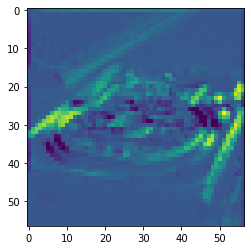

In [44]:
import matplotlib.pyplot as plt 

plt.imshow(activations[0][0][0])

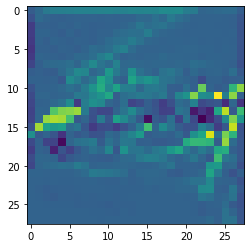

In [43]:
plt.imshow(downsampled_data[0])